Ao analisar os dois arquivos de exemplo fornecidos (em `exemplos/`), é possível observar que produtos equivalentes aparecem na mesma posição. Essa é uma observação importante.

In [1146]:
# imports
import pandas as pd
import seaborn as sns
import Levenshtein
import nltk; nltk.download('rslp')
from nltk.stem import RSLPStemmer
from dotenv import load_dotenv; load_dotenv()
import os
from openai import OpenAI

[nltk_data] Downloading package rslp to /Users/joaoloss/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [1147]:
df_a = pd.read_csv("exemplos/exemplo_fornecedor_a.csv")
df_b = pd.read_csv("exemplos/exemplo_fornecedor_b.csv")

In [1148]:
df_a.head()

,codigo,produto,marca,descricao,preco,categoria,unidade
0,PROD001,Notebook Dell Inspiron 15 8GB,Dell,Notebook 15 polegadas Intel Core i5 8GB RAM 25...,3500.0,Eletrônicos,UN
1,PROD002,Papel A4 500 folhas branco,Chamex,Papel sulfite branco 500 folhas 75g/m²,25.5,Office,RES
2,PROD003,Caneta BIC Azul,BIC,Caneta esferográfica azul ponta média,2.5,Escritório,UN
3,PROD004,Monitor LG 24 polegadas Full HD,LG,"Monitor LED 24"" Full HD 1920x1080 HDMI VGA",850.0,Eletrônicos,UN
4,PROD005,Mesa Escritório Retangular 120cm,Allma,Mesa escritório retangular MDF 120x60cm branca,450.0,Móveis,UN


In [1149]:
df_b.head()

,sku,nome_do_item,fabricante,caracteristicas,valor,ncm,unidade_medida,estoque
0,SKU-789,Notebook Inspiron 15 8GB Intel i5,Dell,"15.6"" Intel Core i5 8GB RAM SSD 256GB Windows 11",3499.90,8471.30.00,UN,25
1,SKU-790,Papel A4 500fls branco 75g,Chamex,Sulfite A4 branco 500 folhas gramatura 75g/m²,24.90,4802.56.00,RES,150
2,SKU-791,Caneta BIC Azul ponta média,BIC,Esferográfica azul ponta média corpo transparente,2.45,Escritório,UN,500
3,SKU-792,"Monitor LG 24"" Full HD",LG,LED 24 polegadas resolução 1920x1080 HDMI VGA ...,845.00,8528.52.00,UN,18
4,SKU-793,Mesa Escritório 120x60cm,Allma,Retangular MDF branca 120cm largura 60cm profu...,445.00,9403.30.00,UN,12


In [1171]:
items_a = list()
for produto, marca, descricao in zip(df_a['produto'], df_a['marca'], df_a['descricao']):
    item = f"{produto} {marca} {descricao}".lower()
    items_a.append(item)

items_b = list()
for nome_do_item, fabricante, caracteristicas in zip(df_b['nome_do_item'], df_b['fabricante'], df_b['caracteristicas']):
    item = f"{nome_do_item} {fabricante} {caracteristicas}".lower()
    items_b.append(item)

if len(items_a) != len(items_b): # Garante que ambos os conjuntos tenham o mesmo tamanho
    min_len = min(len(items_a), len(items_b))
    items_a = items_a[:min_len]
    items_b = items_b[:min_len]

assert len(items_a) == len(items_b)

print(items_a[:5])
print(items_b[:5])

['notebook dell inspiron 15 8gb dell notebook 15 polegadas intel core i5 8gb ram 256gb ssd', 'papel a4 500 folhas branco chamex papel sulfite branco 500 folhas 75g/m²', 'caneta bic azul bic caneta esferográfica azul ponta média', 'monitor lg 24 polegadas full hd lg monitor led 24" full hd 1920x1080 hdmi vga', 'mesa escritório retangular 120cm allma mesa escritório retangular mdf 120x60cm branca']
['notebook inspiron 15 8gb intel i5 dell 15.6" intel core i5 8gb ram ssd 256gb windows 11', 'papel a4 500fls branco 75g chamex sulfite a4 branco 500 folhas gramatura 75g/m²', 'caneta bic azul ponta média bic esferográfica azul ponta média corpo transparente', 'monitor lg 24" full hd lg led 24 polegadas resolução 1920x1080 hdmi vga displayport', 'mesa escritório 120x60cm allma retangular mdf branca 120cm largura 60cm profundidade']


# Testando formas de agrupamento por similaridade de strings

In [1151]:
# Selecionando apenas a raiz das palavras para melhorar a comparação (eliminando variações irrelevantes para o contexto) e performance (menos caracteres)
stemmer = RSLPStemmer()

stemmed_items_a = [" ".join([stemmer.stem(word) for word in item.split()]) for item in items_a]
stemmed_items_b = [" ".join([stemmer.stem(word) for word in item.split()]) for item in items_b]
print(stemmed_items_a[:5])
print(stemmed_items_b[:5])

['notebook dell inspiron 15 8gb dell notebook 15 poleg intel cor i5 8gb ram 256gb ssd', 'papel a4 500 folh branc chamex papel sulfit branc 500 folh 75g/m²', 'canet bic azul bic canet esferográf azul pont méd', 'moni lg 24 poleg full hd lg moni led 24" full hd 1920x1080 hdm vga', 'mes escritóri retangul 120cm allm mes escritóri retangul mdf 120x60cm branc']
['notebook inspiron 15 8gb intel i5 dell 15.6" intel cor i5 8gb ram ssd 256gb window 11', 'papel a4 500fl branc 75g chamex sulfit a4 branc 500 folh gramat 75g/m²', 'canet bic azul pont méd bic esferográf azul pont méd corp transpar', 'moni lg 24" full hd lg led 24 poleg resoluç 1920x1080 hdm vga displayport', 'mes escritóri 120x60cm allm retangul mdf branc 120cm larg 60cm profund']


## Testando Jaccard

A [distância Jaccard](https://en.wikipedia.org/wiki/Jaccard_index) mensura diferença entre conjuntos: 

$$d(X, Y) = 1 - \frac{|X\cap Y|}{|X\cup Y|}.$$

Se $X \approx Y$, então $X\cap Y \approx X\cup Y$. Assim $d(X, Y) \approx 0$. Similarmente, se $X$ e $Y$ são muito distintos, $d(X, Y) \approx 1$.

In [1152]:
def jaccard_distance(x, y):
  inter = len(x.intersection(y))
  union = len(x) + len(y) - inter
  if union == 0:
    return 0
  else:
    return 1 - inter / union

In [1153]:
set_a = [set(item.split()) for item in stemmed_items_a]
set_b = [set(item.split()) for item in stemmed_items_b]

# print(set_a[0]); print(set_b[0])

jaccard_distances = list()
for a in set_a:
    row = list()
    for b in set_b:
        dist = jaccard_distance(a, b)
        row.append(dist)
    jaccard_distances.append(row)

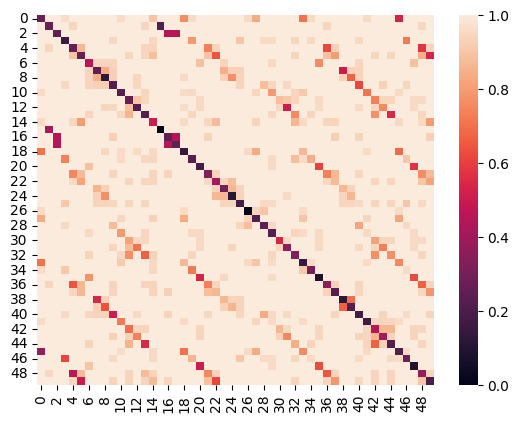

In [1154]:
import seaborn as sns

sns.heatmap(jaccard_distances);

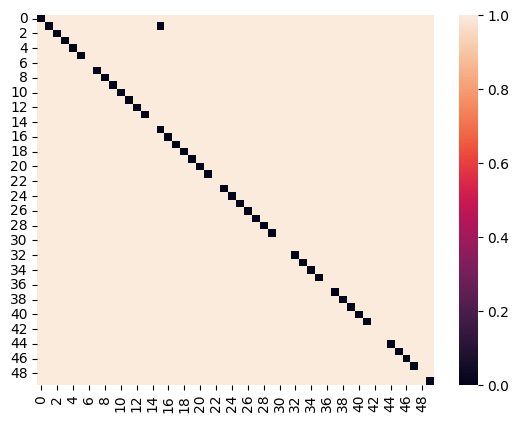

In [1155]:
jaccard_threshold = 0.35 # valor testado empiricamente

filtered_jaccard_distances = list()
for row in jaccard_distances:
    filtered_row = [0.0 if dist < jaccard_threshold else 1.0 for dist in row] # 0.0 para similar, 1.0 para diferente
    filtered_jaccard_distances.append(filtered_row)

sns.heatmap(filtered_jaccard_distances);

In [1156]:
print("Itens cuja similaridade com o correspondente no outro conjunto é menor que o limiar definido:\n")

count = 0
for i, row in enumerate(filtered_jaccard_distances):
    for j, dist in enumerate(row):
        if j == i and dist == 1.0:
            min_dist = min(jaccard_distances[i])
            min_index = jaccard_distances[i].index(min_dist)
            print(f"Item {i} de 'a' | score com item correspondente em 'b': {jaccard_distances[i][i]:.3f} | item correspondente em 'b' é o item mais similar? {f"Não (item {min_index} com score {min_dist:.3f})" if min_index != i else 'Sim'}")
            print(stemmed_items_a[i])
            print(stemmed_items_b[i])
            print("----")
            count += 1

print(f"{count} ({count / len(filtered_jaccard_distances) * 100:.2f}%)")

Itens cuja similaridade com o correspondente no outro conjunto é menor que o limiar definido:

Item 6 de 'a' | score com item correspondente em 'b': 0.462 | item correspondente em 'b' é o item mais similar? Sim
impres hp laserjet pro hp impres las monocromá 1200x1200dp usb wi-f
impres las hp pro m15w hp las monocromá 1200dp usb wi-f impress rápid
----
Item 14 de 'a' | score com item correspondente em 'b': 0.500 | item correspondente em 'b' é o item mais similar? Sim
suport notebook ergonôm allm suport par notebook ajust alumíni até 17"
suport notebook alumíni allm ajust alumíni suport até 17 poleg altur
----
Item 22 de 'a' | score com item correspondente em 'b': 0.417 | item correspondente em 'b' é o item mais similar? Sim
cade gam rgb allm cade gam com ilumin rgb e apoi par pescoç
cade gam rgb allm allm gam ilumin rgb apoi pescoç lomb ajust
----
Item 30 de 'a' | score com item correspondente em 'b': 0.538 | item correspondente em 'b' é o item mais similar? Sim
fon de ouv sony wh-1000x

O resultado acima mostra que, mesmo quando a similaridade entre um item e seu equivalente no outro conjunto não fica abaixo do threshold considerado, o par equivalente ainda apresenta o menor score de similaridade em comparação com os demais pares.

In [1157]:
print("Itens cuja similaridade com outros itens (além do correspondente) do outro conjunto é menor que o limiar definido:\n")

count = 0
for i, row in enumerate(filtered_jaccard_distances):
    for j, dist in enumerate(row):
        if j != i and dist != 1.0:
            min_dist = min(jaccard_distances[i])
            min_index = jaccard_distances[i].index(min_dist)
            print(f"Item {i} de 'a' | score com item correspondente em 'b': {jaccard_distances[i][i]:.3f} | item correspondente em 'b' é o item mais similar? {f"Não (item {min_index} com score {min_dist:.3f})" if min_index != i else 'Sim'}")
            print(stemmed_items_a[i])
            print(stemmed_items_b[j])
            print("----")
            count += 1
print(f"{count} ({count / len(filtered_jaccard_distances) * 100:.2f}%)")

Itens cuja similaridade com outros itens (além do correspondente) do outro conjunto é menor que o limiar definido:

Item 1 de 'a' | score com item correspondente em 'b': 0.273 | item correspondente em 'b' é o item mais similar? Não (item 15 com score 0.222)
papel a4 500 folh branc chamex papel sulfit branc 500 folh 75g/m²
papel a4 500 folh recicl chamex chamex sulfit recicl a4 500 folh 75g/m²
----
1 (2.00%)


O resultado acima apresenta um caso em que um item obteve um score inferior ao threshold ao ser comparado com um produto não equivalente, sendo esse o menor valor observado. Ainda assim, é possível notar que o score em relação ao produto equivalente permaneceu muito próximo, com uma diferença de apenas 0.05.

## Testando Levenshtein

A [distância Levenshtein](https://pt.wikipedia.org/wiki/Dist%C3%A2ncia_Levenshtein) ou distância de edição entre duas sequências de caracteres é dada pelo número mínimo de operações (inserção, deleção ou substituição) necessárias para igualar as duas sequências.

In [1158]:
# Remove espaços para melhorar performance nas comparações
unified_items_a = [item.replace(" ", "") for item in stemmed_items_a]
unified_items_b = [item.replace(" ", "") for item in stemmed_items_b]

print(unified_items_a[:5])
print(unified_items_b[:5])

['notebookdellinspiron158gbdellnotebook15polegintelcori58gbram256gbssd', 'papela4500folhbrancchamexpapelsulfitbranc500folh75g/m²', 'canetbicazulbiccanetesferográfazulpontméd', 'monilg24polegfullhdlgmoniled24"fullhd1920x1080hdmvga', 'mesescritóriretangul120cmallmmesescritóriretangulmdf120x60cmbranc']
['notebookinspiron158gbinteli5dell15.6"intelcori58gbramssd256gbwindow11', 'papela4500flbranc75gchamexsulfita4branc500folhgramat75g/m²', 'canetbicazulpontmédbicesferográfazulpontmédcorptranspar', 'monilg24"fullhdlgled24polegresoluç1920x1080hdmvgadisplayport', 'mesescritóri120x60cmallmretangulmdfbranc120cmlarg60cmprofund']


In [1159]:
lev_distances = list()
for a in unified_items_a:
    row = list()
    for b in unified_items_b:
        dist = Levenshtein.distance(a, b) / max(len(a), len(b))
        row.append(dist)
    lev_distances.append(row)

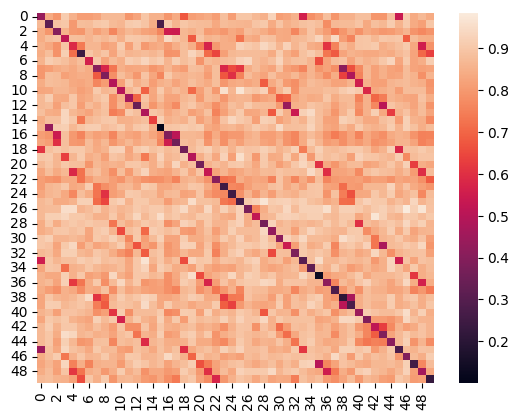

In [1160]:
sns.heatmap(lev_distances);

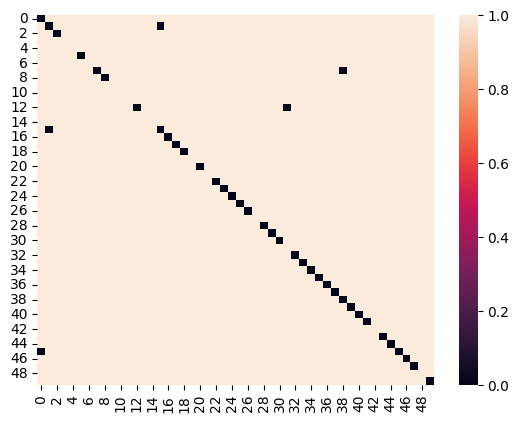

In [1161]:
lev_threshold = 0.45 # valor testado empiricamente

filtered_lev_distances = list()
for row in lev_distances:
    filtered_row = [0.0 if dist < lev_threshold else 1.0 for dist in row]
    filtered_lev_distances.append(filtered_row)
sns.heatmap(filtered_lev_distances);

In [1162]:
print("Itens cuja similaridade com o correspondente no outro conjunto é menor que o limiar definido:\n")

count = 0
for i, row in enumerate(filtered_lev_distances):
    for j, dist in enumerate(row):
        if j == i and dist == 1.0:
            min_dist = min(lev_distances[i])
            min_index = lev_distances[i].index(min_dist)
            print(f"Item {i} de 'a' | score com item correspondente em 'b': {lev_distances[i][i]:.3f} | item correspondente em 'b' é o item mais similar? {f"Não (item {min_index} com score {min_dist:.3f})" if min_index != i else 'Sim'}")
            print(stemmed_items_a[i])
            print(stemmed_items_b[j])
            print("----")
            count += 1
print(f"{count} ({count / len(filtered_lev_distances) * 100:.2f}%)")

Itens cuja similaridade com o correspondente no outro conjunto é menor que o limiar definido:

Item 3 de 'a' | score com item correspondente em 'b': 0.517 | item correspondente em 'b' é o item mais similar? Sim
moni lg 24 poleg full hd lg moni led 24" full hd 1920x1080 hdm vga
moni lg 24" full hd lg led 24 poleg resoluç 1920x1080 hdm vga displayport
----
Item 4 de 'a' | score com item correspondente em 'b': 0.585 | item correspondente em 'b' é o item mais similar? Não (item 48 com score 0.554)
mes escritóri retangul 120cm allm mes escritóri retangul mdf 120x60cm branc
mes escritóri 120x60cm allm retangul mdf branc 120cm larg 60cm profund
----
Item 6 de 'a' | score com item correspondente em 'b': 0.561 | item correspondente em 'b' é o item mais similar? Sim
impres hp laserjet pro hp impres las monocromá 1200x1200dp usb wi-f
impres las hp pro m15w hp las monocromá 1200dp usb wi-f impress rápid
----
Item 9 de 'a' | score com item correspondente em 'b': 0.492 | item correspondente em 'b' é

In [1163]:
print("Itens cuja similaridade com outros itens (além do correspondente) do outro conjunto é menor que o limiar definido:\n")

count = 0
for i, row in enumerate(filtered_lev_distances):
    for j, dist in enumerate(row):
        if j != i and dist != 1.0:
            min_dist = min(lev_distances[i])
            min_index = lev_distances[i].index(min_dist)
            print(f"Item {i} de 'a' | score com item correspondente em 'b': {lev_distances[i][i]:.3f} | item correspondente em 'b' é o item mais similar? {f"Não (item {min_index} com score {min_dist:.3f})" if min_index != i else 'Sim'}")
            print(stemmed_items_a[i])
            print(stemmed_items_b[j])
            print("----")
            count += 1
print(f"{count} ({count / len(filtered_lev_distances) * 100:.2f}%)")

Itens cuja similaridade com outros itens (além do correspondente) do outro conjunto é menor que o limiar definido:

Item 1 de 'a' | score com item correspondente em 'b': 0.310 | item correspondente em 'b' é o item mais similar? Não (item 15 com score 0.271)
papel a4 500 folh branc chamex papel sulfit branc 500 folh 75g/m²
papel a4 500 folh recicl chamex chamex sulfit recicl a4 500 folh 75g/m²
----
Item 7 de 'a' | score com item correspondente em 'b': 0.407 | item correspondente em 'b' é o item mais similar? Sim
tecl logitech usb logitech tecl usb padr abnt2 portugu
tecl sem fio logitech 2.4ghz logitech sem fio 2.4ghz padr abnt2 portugu bat
----
Item 12 de 'a' | score com item correspondente em 'b': 0.339 | item correspondente em 'b' é o item mais similar? Sim
caix de som jbl go 3 jbl caix de som bluetooth portátil à prov d'águ
caix som jbl flip 6 bluetooth jbl bluetooth portátil stere 30w à prov d'águ ipx7
----
Item 15 de 'a' | score com item correspondente em 'b': 0.102 | item corresp

Resultado um pouco inferior ao obtido utilizando Jaccard.

## Combinando Levenshtein and Jaccard

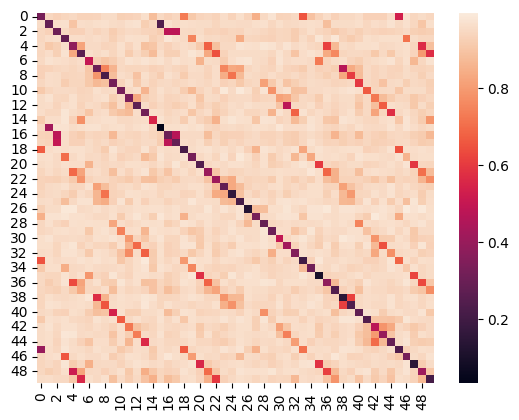

In [1164]:
combined_distances = list()
for row_jaccard, row_lev in zip(jaccard_distances, lev_distances):
    combined_row = [(j * 1.30 + l * 0.70) / 2 for j, l in zip(row_jaccard, row_lev)]
    combined_distances.append(combined_row)

sns.heatmap(combined_distances);

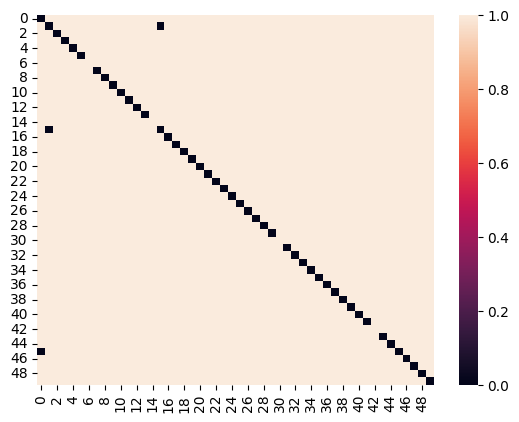

In [1165]:
combined_threshold = 0.45 # valor testado empiricamente

filtered_combined_distances = list()
for row in combined_distances:
    filtered_row = [0.0 if dist < combined_threshold else 1.0 for dist in row]
    filtered_combined_distances.append(filtered_row)
sns.heatmap(filtered_combined_distances);

In [1166]:
print("Itens cuja similaridade com o correspondente no outro conjunto é menor que o limiar definido:\n")

count = 0
for i, row in enumerate(filtered_combined_distances):
    for j, dist in enumerate(row):
        if j == i and dist == 1.0:
            min_dist = min(combined_distances[i])
            min_index = combined_distances[i].index(min_dist)
            print(f"Item {i} de 'a' | score com item correspondente em 'b': {combined_distances[i][i]:.3f} | item correspondente em 'b' é o item mais similar? {f"Não (item {min_index} com score {min_dist:.3f})" if min_index != i else 'Sim'}")
            print(stemmed_items_a[i])
            print(stemmed_items_b[j])
            print("----")
            count += 1
print(f"{count} ({count / len(filtered_combined_distances) * 100:.2f}%)")

Itens cuja similaridade com o correspondente no outro conjunto é menor que o limiar definido:

Item 6 de 'a' | score com item correspondente em 'b': 0.496 | item correspondente em 'b' é o item mais similar? Sim
impres hp laserjet pro hp impres las monocromá 1200x1200dp usb wi-f
impres las hp pro m15w hp las monocromá 1200dp usb wi-f impress rápid
----
Item 14 de 'a' | score com item correspondente em 'b': 0.547 | item correspondente em 'b' é o item mais similar? Sim
suport notebook ergonôm allm suport par notebook ajust alumíni até 17"
suport notebook alumíni allm ajust alumíni suport até 17 poleg altur
----
Item 30 de 'a' | score com item correspondente em 'b': 0.494 | item correspondente em 'b' é o item mais similar? Sim
fon de ouv sony wh-1000xm4 sony fon de ouv over- bluetooth com cancel de ruíd
fon over- sony wh1000xm4 sony over- bluetooth cancel ruíd ativ bat
----
Item 42 de 'a' | score com item correspondente em 'b': 0.476 | item correspondente em 'b' é o item mais similar? Sim


In [1167]:
print("Itens cuja similaridade com outros itens (além do correspondente) do outro conjunto é menor que o limiar definido:\n")

count = 0
for i, row in enumerate(filtered_combined_distances):
    for j, dist in enumerate(row):
        if j != i and dist == 0.0:
            min_dist = min(combined_distances[i])
            min_index = combined_distances[i].index(min_dist)
            print(f"Item {i} de 'a' | score com item correspondente em 'b': {combined_distances[i][i]:.3f} | item correspondente em 'b' é o item mais similar? {f"Não (item {min_index} com score {min_dist:.3f})" if min_index != i else 'Sim'}")
            print(stemmed_items_a[i])
            print(stemmed_items_b[j])
            print("----")
            count += 1
print(f"{count} ({count / len(filtered_combined_distances) * 100:.2f}%)")

Itens cuja similaridade com outros itens (além do correspondente) do outro conjunto é menor que o limiar definido:

Item 1 de 'a' | score com item correspondente em 'b': 0.286 | item correspondente em 'b' é o item mais similar? Não (item 15 com score 0.239)
papel a4 500 folh branc chamex papel sulfit branc 500 folh 75g/m²
papel a4 500 folh recicl chamex chamex sulfit recicl a4 500 folh 75g/m²
----
Item 15 de 'a' | score com item correspondente em 'b': 0.036 | item correspondente em 'b' é o item mais similar? Sim
papel a4 500 folh recicl chamex papel sulfit recicl 500 folh 75g/m²
papel a4 500fl branc 75g chamex sulfit a4 branc 500 folh gramat 75g/m²
----
Item 45 de 'a' | score com item correspondente em 'b': 0.236 | item correspondente em 'b' é o item mais similar? Sim
notebook asu vivobook 15 asu notebook 15.6" intel cor i5 8gb ram 256gb ssd
notebook inspiron 15 8gb intel i5 dell 15.6" intel cor i5 8gb ram ssd 256gb window 11
----
3 (6.00%)


## Conclusão

Combinar as medidas de dissimilaridade resultou em uma pequena melhora.

# Testando LLM

In [ ]:
model_name = "gpt-5-nano-2025-08-07" # Motivo da escolha: segundo a documentação, essa é a versão mais barata e rápida do modelo GPT-5, ideal para o tipo de tarefa proposta
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [1183]:
selecting_cols_prompt = """
Seu papel é retornar as colunas cujas informações descrevem o item de forma completa e precisa. Retorne apenas os nomes das colunas separados por vírgula, nada mais.

Colunas disponíveis: {cols}
Exemplo de um item: {item}

Responda imediatamente apenas com os nomes das colunas.
"""

In [1211]:
print(selecting_cols_prompt.format(cols=", ".join(df_a.columns), item=items_a[0]))

response = client.responses.create(
    model=model_name,
    instructions="",
    input=selecting_cols_prompt.format(cols=", ".join(df_a.columns), item=items_a[0]),
    reasoning={"effort": "low"}
)
print(response.output_text)

response = client.responses.create(
    model=model_name,
    instructions="",
    input=selecting_cols_prompt.format(cols=", ".join(df_b.columns), item=items_b[0]),
    reasoning={"effort": "low"}
)
print(response.output_text)


Seu papel é retornar as colunas cujas informações descrevem o item de forma completa e precisa. Retorne apenas os nomes das colunas separados por vírgula, nada mais.

Colunas disponíveis: codigo, produto, marca, descricao, preco, categoria, unidade
Exemplo de um item: notebook dell inspiron 15 8gb dell notebook 15 polegadas intel core i5 8gb ram 256gb ssd

Responda imediatamente apenas com os nomes das colunas.

produto, marca, descricao
nome_do_item, fabricante, caracteristicas


In [ ]:
prompt = """
Seu papel é identificar quais colunas descrevem diretamente o item em si (modelo, marca ou características), e não informações administrativas ou operacionais.

Retorne apenas os nomes das colunas relevantes, separados por vírgula, sem qualquer texto adicional. Jamais invente ou adicione colunas que não estejam presentes na lista fornecida. Ignore colunas como código, preço, quantidade, estoque, unidade ou identificadores técnicos. Considere apenas colunas que descrevem o item de forma específica, como nome do produto, marca e descrição textual.

Colunas disponíveis: {cols}

Exemplo de item:
{item}

Responda imediatamente apenas com os nomes das colunas separados por vírgula.
"""

response = client.responses.create(
    model=model_name,
    instructions="",
    input=prompt,
    reasoning={"effort": "low"}
)
print(response.output_text)

produto, marca, descricao


In [1197]:
comparing_items_prompt = """
Seu papel é comparar dois itens e determinar se eles são equivalentes, ou seja, se descrevem o mesmo produto, mesmo que com palavras diferentes. Considere que os itens podem ter pequenas variações na descrição, mas ainda assim serem equivalentes.
Responda apenas com S, para sim, ou N, para não.

Item 1: {item1}
Item 2: {item2}

Responda imediatamente com S ou N.
"""

In [1205]:
itens_to_compare = [(items_a[6], items_b[6]), (items_a[19], items_b[19]), (items_a[1], items_b[15])]
itens_to_compare

[('impressora hp laserjet pro hp impressora laser monocromática 1200x1200dpi usb wi-fi',
  'impressora laser hp pro m15w hp laser monocromática 1200dpi usb wi-fi impressão rápida'),
 ('monitor samsung 27 polegadas 4k samsung monitor led 27" 4k uhd 3840x2160 hdmi displayport',
  'monitor samsung 27" 4k uhd samsung led 27 polegadas 4k resolução 3840x2160 hdmi dp'),
 ('papel a4 500 folhas branco chamex papel sulfite branco 500 folhas 75g/m²',
  'papel a4 500 folhas reciclado chamex chamex sulfite reciclado a4 500 folhas 75g/m²')]

In [1206]:
for item1, item2 in itens_to_compare:
    response = client.responses.create(
        model=model_name,
        instructions="",
        input=comparing_items_prompt.format(item1=item1, item2=item2),
        reasoning={"effort": "low"}
    )
    print(response.output_text)

# Resposta esperada: S S N

S
S
N


In [1207]:
cols_a = set(df_a.columns)
cols_a

{'categoria', 'codigo', 'descricao', 'marca', 'preco', 'produto', 'unidade'}

In [1209]:
hash(frozenset(cols_a))

3498581806326401377